Our code here is inspired by https://github.com/andrewwlong/deep_arrhythmias/blob/master/Arrythmia%20Project.ipynb, yet ours is quite different in the segmentation technique

In [1]:
pip install wfdb # to read wave signal data bases

     |████████████████████████████████| 122kB 6.7MB/s 
     |████████████████████████████████| 6.8MB 7.4MB/s 
     |████████████████████████████████| 163kB 47.7MB/s 
  Created wheel for wfdb: filename=wfdb-3.1.1-cp36-none-any.whl size=117829 sha256=bc2d82ffff1105c322d52c0eac2309b2d14a52ec84c3299e13f2c2e285661bdc
  Stored in directory: /root/.cache/pip/wheels/bc/d0/c1/90538d266ccba2d1076fbc9970192c7ea1a09c99df3e65c69b
Successfully built wfdb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.signal import savgol_filter

import wfdb # 

In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/INCART12/I'

pts = [] # to collect patients ids

for pt in range(1,76):
    if pt <10:
        pts.append('0'+str(pt))
    else:
        pts.append(str(pt))

In [5]:
len(pts) # number of patients

75

In [6]:
df = pd.DataFrame()  # to collect the signals data

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

Take a look at the annotations we have

In [7]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    150410
V     20013
R      3174
A      1944
F       219
j        92
n        32
S        16
+        12
Q         6
B         1
Name: val, dtype: int64

In [15]:
# list of abnormal beats from physionet, we just use it for the plot below
#nonbeat = ['[','!',']','x','(',')','p','t','u','`',
 #          '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [9]:
#Let's write a function for loading a single patient's signals and annotations. Note the annotation values are the indices of the signal array.

def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is fs = 257
    assert record.fs == 257, 'sample freq is not 257'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

Let's check out what abnormal beats are in a patient's ecg:

In [10]:
file = data_path + pts[0]

In [11]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [12]:
np.shape(p_signal)

(462600, 12)

As we can see, 12 leads or channels

In [16]:
# get abnormal beat index to show on plot

ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[710, 2656, 5263, 8541, 10895, 16053, 17328, 18130, 18934, 22275]

In [17]:
x = np.arange(len(p_signal))

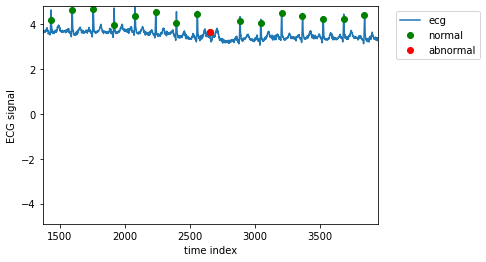

In [19]:
left = ab_index[1]-1285 # 5s before first abnormal beat
right = ab_index[1]+1285 #5s after

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

As we can see, not normalized. Note that the circles are at the R peaks (atr_sample)

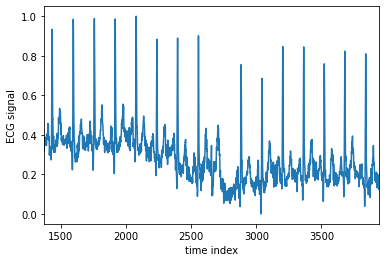

In [23]:
# Let's see how it looks when normalized

p_normal = (p_signal[left:right,0] - p_signal[left:right,0].min()) / (p_signal[left:right,0].max() - p_signal[left:right,0].min())
atr_window = atr_sample[left:right]
plt.plot(x[left:right],p_normal,'-',label='ecg',)


plt.xlim(left,right)
plt.ylim(p_normal.min()-0.05,p_normal.max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')

plt.show()

Let's make our dataset

In [33]:
def make_dataset(num_cols,pts,lead, num_sec, fs, fs_down):
    # function for making dataset ignoring non-beats
    # input:
    # a predefined width enough to capture any [R, R+1.2*T] interval
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency (we take 257Hz as the data were collected accordingly)
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    
    X_all = np.zeros((1,num_cols))
    Y_all = []
    
    window_width = fs*num_sec
    
    for pt in pts:
        p_signal, atr_sym, atr_sample = load_ecg(data_path + str(pt))
        
        # grab a lead signal
        p_signal_lead = p_signal[:,lead]
         
        # exclude the nonbeats  
        #df_ann = pd.DataFrame({'atr_sym':atr_sym,
         #                       'atr_sample':atr_sample})
        #df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
            
        begin_window = 0 #point at which we start/end a window (of length num_sec seconds)

        while begin_window  < len(p_signal_lead):
            
            end_window = begin_window + window_width
            
            r_in_window = np.where((atr_sample >= begin_window) & (atr_sample < end_window)) #indices of R peaks in the window
            p_window = p_signal_lead[begin_window: end_window] #we use this for normalization
            # we can quickly compute the segment size
            atr_sample_window = atr_sample[r_in_window] #the R peak points of that window
            segment_size = math.ceil(1.2*np.median(atr_sample_window[1:] - np.roll(atr_sample_window,1)[1:])) #interval width

            begin_window = end_window #we don't need begin_window for this loop anymore so we set it for the next loop

            X,Y = build_XY(p_signal_lead,p_window,segment_size,atr_sample,atr_sym,r_in_window, num_cols, fs, fs_down)
            
            X_all = np.append(X_all,X,axis = 0)
            Y_all = Y_all+Y
            
                
    # drop the first zero row
    X_all = X_all[1:,:]

    return X_all, Y_all 

######################

def build_XY(p_signal_lead,p_window,segment_size,atr_sample,atr_sym,r_in_window, num_cols, fs, fs_down):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(r_in_window[0]) # that r_in_window is a tuple (ordered pair)
    
    X = np.zeros((num_rows, num_cols))
    Y = []

    for index in range(num_rows):
        
        r_in_window_index = r_in_window[0][index]
        
        left = atr_sample[r_in_window_index]
        right = left + segment_size

        # put the [R,R+1.2*T] interval as a row in X, but first downsample (to 125 Hz)
        signal_vector = p_signal_lead[left: right]

        downsample_size = math.floor(len(signal_vector) * fs_down/fs)

        signal_vector_downsampled  = signal.resample(signal_vector, downsample_size)

        X[index,:downsample_size] =  savgol_filter((signal_vector_downsampled - p_window.min())/(p_window.max() - p_window.min()),9,2)  # you may chose not to make that scaling/shifting if your modeling puposes do require
        #we chose to scale this way just to be as close as possible to the desciption in the paper!
        #Preprocessed data we found seem to be smoothened

        Y += [atr_sym[r_in_window_index]]


    return X,Y 

In [34]:
num_sec = 10
fs = 257
fs_down = 125
lead = 0

num_cols = 251 # found by trial and error

Before proceeding to this code, be warned that it may crash your RAMS because of how huge the tables are. We have a fix for that in the cell after

In [ ]:
X_all, Y_all = make_dataset(num_cols,pts,lead, num_sec, fs, fs_down)

If the code above takes forever (huge table), or crashes the RAM, do build mini portions of it (patient 1-10, 11-20,..) then glue them together by vstack. This is how we did it (written below at the end). Also this had the benefit to confirm that the code was not taking long due to any bugs.

In [35]:
X_all, Y_all = make_dataset(num_cols,pts[0:10],lead, num_sec, fs, fs_down)

In [38]:
X_all2, Y_all2 = make_dataset(num_cols,pts[10:20],lead, num_sec, fs, fs_down)

In [39]:
X_all3, Y_all3 = make_dataset(num_cols,pts[20:30],lead, num_sec, fs, fs_down)

In [40]:
X_all4, Y_all4 = make_dataset(num_cols,pts[30:40],lead, num_sec, fs, fs_down)

In [41]:
X_all5, Y_all5 = make_dataset(num_cols,pts[40:50],lead, num_sec, fs, fs_down)

In [42]:
X_all6, Y_all6 = make_dataset(num_cols,pts[50:60],lead, num_sec, fs, fs_down)

In [43]:
X_all7, Y_all7 = make_dataset(num_cols,pts[60:70],lead, num_sec, fs, fs_down)

In [44]:
X_all8,  Y_all8 = make_dataset(num_cols,pts[70:],lead, num_sec, fs, fs_down)

In [45]:
XX = np.vstack((X_all,X_all2))
XX = np.vstack((XX,X_all3))
XX = np.vstack((XX,X_all4))
XX = np.vstack((XX,X_all5))
XX = np.vstack((XX,X_all6))
XX = np.vstack((XX,X_all7))
XX = np.vstack((XX,X_all8))

In [46]:
YY = np.hstack((Y_all,Y_all2))
YY = np.hstack((YY,Y_all3))
YY = np.hstack((YY,Y_all4))
YY = np.hstack((YY,Y_all5))
YY = np.hstack((YY,Y_all6))
YY = np.hstack((YY,Y_all7))
YY = np.hstack((YY,Y_all8))

In [47]:
dfX = pd.DataFrame(XX,index = None)

In [ ]:
dfX.to_csv('/content/drive/MyDrive/Colab Notebooks/INCART12/X_lead0_dws_smoother.csv')

In [48]:
YYY= YY.reshape(YY.shape[0],1)

In [ ]:
dfY = pd.DataFrame(YYY,index = None)
dfY.to_csv('/content/drive/MyDrive/Colab Notebooks/INCART12/Y_lead0_dws.csv')

We produced the labels and data points separately because hstacking them takes forever and could crash the RAM.

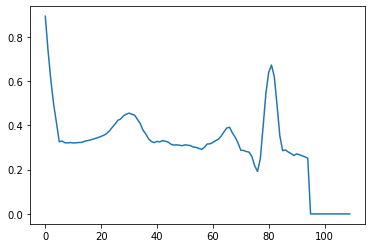

In [51]:
# a plot of one of our data points

plt.plot(range(110),X_all[5,:110])

Remark: In the paper on which our project is founded, the find the R peaks not using atr_sample (which they seemd not to have available). They found those peaks by hunting for signal points that are above 0.9. In what follows, we show the mofications of our functions which implement that approach.

In [53]:
def make_dataset(num_cols,pts,lead, num_sec, fs, fs_down):
    # function for making dataset ignoring non-beats
    # input:
    # a predefined width enough to capture any [R, R+1.2*T] interval
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency (we take 257Hz as the data were collected accordingly)
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    
    X_all = np.zeros((1,num_cols))
    Y_all = []
    
    window_width = fs*num_sec
    
    for pt in pts:
        p_signal, atr_sym, atr_sample = load_ecg(data_path + str(pt))
        
        # grab a lead signal
        p_signal_lead = p_signal[:,lead]
         
            
        begin_window = 0 #point at which we start/end a window (of length num_sec seconds)

        while begin_window  < len(p_signal_lead):
            
            end_window = begin_window + window_width
            
            # here are the changes
            p_window = p_signal_lead[begin_window: end_window] #we use this for normalization 
            p_normalized = (p_window - p_window.min())/(p_window.max()-p_window.min())
            at_R = np.where(p_normalized >=0.9)[0]
            r_in_window = np.where((at_R >= begin_window) & (at_R < end_window))
            segment_size = math.ceil(1.2*np.median(at_R[1:] - np.roll(at_R,1)[1:]))

            begin_window = end_window #we don't need begin_window for this loop anymore so we set it for the next loop

            X,Y = build_XY(p_signal_lead,p_window,segment_size,at_R,atr_sym,r_in_window, num_cols, fs, fs_down)
            
            X_all = np.append(X_all,X,axis = 0)
            Y_all = Y_all+Y
            
                
    # drop the first zero row
    X_all = X_all[1:,:]

    return X_all, Y_all 

######################

def build_XY(p_signal_lead,p_window,segment_size,at_R,atr_sym,r_in_window, num_cols, fs, fs_down):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(r_in_window[0]) # that r_in_window is a tuple (ordered pair)
    
    X = np.zeros((num_rows, num_cols))
    Y = []

    for index in range(num_rows):
        
        r_in_window_index = r_in_window[0][index]
        
        left = at_R[r_in_window_index]
        right = left + segment_size

        # put the [R,R+1.2*T] interval as a row in X, but first downsample (to 125 Hz)
        signal_vector = p_signal_lead[left: right]

        downsample_size = math.floor(len(signal_vector) * fs_down/fs)

        signal_vector_downsampled  = signal.resample(signal_vector, downsample_size)

        X[index,:downsample_size] =  savgol_filter((signal_vector_downsampled - p_window.min())/(p_window.max() - p_window.min()),9,2)  # you may chose not to make that scaling/shifting if your modeling puposes do require
        #we chose to scale this way just to be as close as possible to the desciption in the paper!
        #Preprocessed data we found seem to be smoothened

        Y += [atr_sym[r_in_window_index]]


    return X,Y 